In [30]:
# import sys
# !{sys.executable} -m pip install numpy --upgrade
# !{sys.executable} -m pip uninstall -y tensorflow-macos
# !{sys.executable} -m pip install tensorflow-macos

In [31]:
import pandas as pd
import ast
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

In [32]:
import torch
print("Is GPU available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))

Is GPU available: True
GPU Name: Tesla T4


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
%cd 'drive/MyDrive/CV_2024/FinalProject/nutri_estimate/nutri_estimate/resnet101_image_model'
%pwd

[Errno 2] No such file or directory: 'drive/MyDrive/CV_2024/FinalProject/nutri_estimate/nutri_estimate/resnet101_image_model'
/content/drive/MyDrive/CV_2024/FinalProject/nutri_estimate/nutri_estimate/resnet101_image_model


'/content/drive/My Drive/CV_2024/FinalProject/nutri_estimate/nutri_estimate/resnet101_image_model'

In [35]:
# Load the JSON files
classes = pd.read_json('../preprocess/classes.json')
df = pd.read_json('../preprocess/preprocessed_data.json', dtype={'label': 'str', 'total_mass': 'float64'})

In [36]:
classes.head(3)

,ingr,mass,count,mass_weight,count_weight
36,egg whites,47794.333297,200,1.000000,3.74500
48,chicken,46796.594974,400,1.021321,1.87250
33,scrambled eggs,39772.309517,331,1.201699,2.26284


In [37]:
df = pd.read_json(
    '../preprocess/preprocessed_data.json',
    dtype={'label': 'str', 'total_mass': 'float64'}
)
df.head(3)

,id,total_calories,total_mass,total_fat,total_carb,total_protein,label,image_link,split
0,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"['brown rice', 'pork', 'mixed greens']",./data/dish_1561662216/camera_A_frame_002.jpeg,test
1,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"['brown rice', 'pork', 'mixed greens']",./data/dish_1561662216/camera_D_frame_002.jpeg,test
2,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"['brown rice', 'pork', 'mixed greens']",./data/dish_1561662216/camera_C_frame_002.jpeg,test


In [38]:
df['label'] = df['label'].apply(ast.literal_eval)

In [39]:
df.head(3)

,id,total_calories,total_mass,total_fat,total_carb,total_protein,label,image_link,split
0,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"[brown rice, pork, mixed greens]",./data/dish_1561662216/camera_A_frame_002.jpeg,test
1,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"[brown rice, pork, mixed greens]",./data/dish_1561662216/camera_D_frame_002.jpeg,test
2,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"[brown rice, pork, mixed greens]",./data/dish_1561662216/camera_C_frame_002.jpeg,test


In [40]:
x_col = 'image_link'
y_col = 'label'
image_size = 320
input_shape = (image_size, image_size, 3)
directory = './preprocess'

In [41]:
X_train = df[df['split'] == 'train']
X_test = df[df['split'] == 'test']
X_train.shape, X_test.shape

((49444, 9), (9879, 9))

In [42]:
X_train = df[df['split'] == 'train']
X_test = df[df['split'] == 'test']
X_train.shape, X_test.shape

((49444, 9), (9879, 9))

In [43]:
# Define custom PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.class_list = list(classes['ingr'].values)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_list)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.root_dir, row['image_link'])
        image = Image.open(image_path).convert("RGB")
        labels = torch.zeros(len(self.class_list))
        for label in row['label']:
            labels[self.class_to_idx[label]] = 1
        if self.transform:
            image = self.transform(image)
        return image, labels

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=(1, 1.5)),
    transforms.ToTensor()
])

In [44]:
# Use this cell for training on a smaller dataset

from torch.utils.data import Subset
import numpy as np

train_dataset = CustomDataset(X_train, '../preprocess', transform=transform)
test_dataset = CustomDataset(X_test, '../preprocess', transform=transform)

batch_size = 8

# Get 20% of the training dataset
subset_size = int(0.2 * len(train_dataset))  # 20% of the total dataset
subset_indices = np.random.choice(len(train_dataset), size=subset_size, replace=False)
train_subset = Subset(train_dataset, subset_indices)

# Create a DataLoader for the subset
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [45]:
print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Print the sizes of the dataloaders (to verify correct data handling)
print(f"Number of Batches in Train Loader: {len(train_loader)}")
print(f"Number of Batches in Test Loader: {len(test_loader)}")

Training Dataset Size: 49444
Test Dataset Size: 9879
Number of Batches in Train Loader: 1236
Number of Batches in Test Loader: 1235


In [46]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet101

# Define the model
class MultiLabelResNet(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelResNet, self).__init__()
        self.base_model = resnet101(weights="IMAGENET1K_V1")
        in_features = self.base_model.fc.in_features  # Input features of the original FC layer
        # self.dropout = nn.Dropout(0.5)
        self.base_model.fc = nn.Sequential(
            # self.dropout,
            nn.Linear(in_features, num_classes)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.base_model(x)
        return self.sigmoid(x)


num_classes = len(classes['ingr'])
model = MultiLabelResNet(num_classes)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
import torch
torch.cuda.empty_cache()

**Hyperparameter tuning:**

**Learning rate:**

Experimented with different learning rates - 1e-3, 1e-4 and 1e-5 and achieved highest accuracy with learning rate = 1e-5

In [48]:
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=1e-3) # Hyperparameter tuning with learning_rate

# Directory to save model weights
save_dir = "saved_models_resnet101"
os.makedirs(save_dir, exist_ok=True)

# Training loop
epochs = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Training loop with validation
for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss
    train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Store predictions and true labels for metrics calculation
            preds = (outputs > 0.5).float()
            y_true.append(labels.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    # Calculate validation loss
    val_loss /= len(test_loader)

    # Calculate validation metrics
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='samples')
    recall = recall_score(y_true, y_pred, average='samples')

    # Print training and validation metrics
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # Save model weights
    model_save_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), model_save_path)
    print(f"Model weights saved to {model_save_path}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
Training Loss: 0.1171
Validation Loss: 0.1232
Validation Accuracy: 0.0054, Precision: 0.0299, Recall: 0.0240
Model weights saved to saved_models_resnet101/model_epoch_1.pth


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/5
Training Loss: 0.1075
Validation Loss: 0.1099
Validation Accuracy: 0.0353, Precision: 0.1251, Recall: 0.0910
Model weights saved to saved_models_resnet101/model_epoch_2.pth


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/5
Training Loss: 0.1010
Validation Loss: 0.1061
Validation Accuracy: 0.0447, Precision: 0.1436, Recall: 0.1043
Model weights saved to saved_models_resnet101/model_epoch_3.pth


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/5
Training Loss: 0.0939
Validation Loss: 0.0999
Validation Accuracy: 0.0594, Precision: 0.1744, Recall: 0.1312
Model weights saved to saved_models_resnet101/model_epoch_4.pth


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/5
Training Loss: 0.0876
Validation Loss: 0.1004
Validation Accuracy: 0.0940, Precision: 0.2593, Recall: 0.1880
Model weights saved to saved_models_resnet101/model_epoch_5.pth


In [49]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the saved model weights
checkpoint_path = "saved_models_resnet101/model_epoch_5.pth"  # Adjust according to last epoch, curr one was done on 5 epochs
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

# Calculate metrics
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='samples')
recall = recall_score(y_true, y_pred, average='samples')

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

<ipython-input-49-8f5ada22a797>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Accuracy: 0.09434153254377974, Precision: 0.26134344617490685, Recall: 0.18939163882984109


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
# Save model
torch.save(model.state_dict(), 'model_resnet101.pth')

# Load model
model = MultiLabelResNet(num_classes)
model.load_state_dict(torch.load('model_resnet101.pth'))
model = model.to(device)

<ipython-input-50-8992aeed7d81>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_resnet101.pth'))


<ipython-input-51-fb64d3dd2586>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


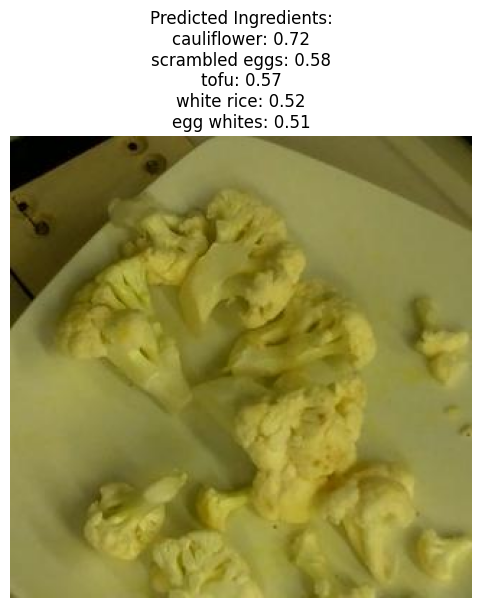

[('cauliflower', 0.7231046), ('scrambled eggs', 0.5800843), ('tofu', 0.569304), ('white rice', 0.51595455), ('egg whites', 0.51179504), ('chicken', 0.5089117), ('hash browns', 0.5078145), ('caesar salad', 0.5077853), ('cantaloupe', 0.5069546), ('avocado', 0.5058227), ('oatmeal', 0.5052769), ('eggs', 0.50469476), ('apple', 0.5045535), ('fish', 0.50370044), ('sweet potato', 0.5033662), ('honeydew melons', 0.5029999), ('tomatoes', 0.50299054), ('mixed greens', 0.50295246), ('corn on the cob', 0.50280756), ('pears', 0.5023935), ('potatoes', 0.50228065), ('sausage', 0.5022247), ('yam', 0.5022246), ('beef', 0.50157183), ('ham', 0.5012142), ('watermelon', 0.50107914), ('strawberries', 0.50097066), ('cucumbers', 0.5008845), ('bacon', 0.50064564), ('olives', 0.5004712), ('mushroom', 0.50046164), ('brussels sprouts', 0.5004405), ('cheese pizza', 0.50043756), ('carrot', 0.50039995), ('broccoli', 0.50037247), ('grapes', 0.50030845), ('chicken apple sausage', 0.50024146), ('eggplant', 0.50023586), 

In [51]:
from PIL import Image
import matplotlib.pyplot as plt

def predict_and_display(model, image_path, checkpoint_path, transform, classes):
    # Load the model weights
    model.load_state_dict(torch.load(checkpoint_path))
    model = model.to(device)
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    preprocessed_image = transform(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(preprocessed_image)  # Get raw predictions (confidence scores)
        confidence_scores = outputs.sigmoid().cpu().numpy()[0]  # Apply sigmoid for probabilities

    # Extract the list of ingredient names
    class_list = classes['ingr'].tolist()

    # Get predicted labels with confidence scores above a threshold (e.g., 0.5)
    threshold = 0.5
    predicted_labels_with_scores = [
        (class_list[i], confidence_scores[i])
        for i in range(len(confidence_scores))
        if confidence_scores[i] > threshold
    ]

    # Sort predictions by confidence scores in descending order
    predicted_labels_with_scores = sorted(predicted_labels_with_scores, key=lambda x: x[1], reverse=True)

    # Prepare a string for displaying predictions with scores
    prediction_text = "\n".join([f"{label}: {score:.2f}" for label, score in predicted_labels_with_scores[:5]])

    # Display the image and predictions
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted Ingredients:\n{prediction_text}", fontsize=12)
    plt.show()

    return predicted_labels_with_scores

# Example Usage:
checkpoint_path = "saved_models_resnet101/model_epoch_5.pth"  # Path to last saved model checkpoint
random_image_path = "../preprocess/" + X_test.sample(1)['image_link'].values[0]

predicted_labels_with_scores = predict_and_display(model, random_image_path, checkpoint_path, transform, classes)
print(predicted_labels_with_scores)